# Versuch 3: Vortrainiertes Faltungsnetz

## Einleitung

Ziel dieses Versuch ist es ein vortrainiertes Faltungsnetz für die Klassifizierung zu verwenden. Dabei wurden die obersten Faltungsschichten eingefroren.  

## Versuchsbeschreibung

Als Vorlage wird das [Xception](https://arxiv.org/pdf/1610.02357.pdf) Faltungsnetz genutzt. Von den mit Keras unterstützden Modelle hat diese nach der Keras [Dokumentation](https://keras.io/applications/) die höchste Top-5 accuracy. Dieser Wert richtet sich nach dem Validierungsergebnis des ImageNet Datensatz. Weitere vortrainierte Modelle gibt es auch unter [Tensorflow Model Zoo](https://github.com/tensorflow/models) oder [Caffe's Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo#googlenet_cars-on-car-model-classification).  

## Versuch 3.1

### Versuchsaufbau

In diesem Versuch wurde als vortrainiertes Faltungsnetz Xception benutzt. Dabei wurden als Trainigsdaten die Datensätze 43, 45 bis 51 verwendet. Die Bilder mussten vorher neu zugeschnitten werden auf $383px$ x $72px$, weil die minimale Breite und Höhe der Bilder $71px$ beträgt. Von den 132 Schichten waren die letzten 3 trainierbar. Die Anzahl der Epochen betrug 10. Als Optimierungsfunktion wurde Adam genutzt mit einer Lernrate von $0.00004$. Womit über ein überanpassung verhindert werden sollte. 

### Erwartung

Erwartet wurde eine niedrigere validierungs accuracy als in Versuch 2.3.4 (5.4). Mit der Begründung, dass das Faltungsnetzwerk mit dem ImageNet Datensatz vortrainiert wurde und nicht mit den Daten die bei diesem Versuch benutzt werden. 

### Ergebnis

Wie auf Abb. 3.1 und 3.2 zu sehen ist das Modell überangepasst. Auf Abb. 3.3. ist zu sehen, dass vorwiegend die Klasse schlecht vorhergesagt wurde. Die Test accuracy betrug nur $39.13\%$ siehe Tab. 3.1.

<img src="../daten/abbildungen/trainingshistorieAccuracyVersuch3_1.png" alt"Trainingshistorie accuracy Versuch 3.1" />
Abbildung 3.1: Trainingshistorie accuracy Versuch 3.1

<img src="../daten/abbildungen/trainingshistorieLossVersuch3_1.png" alt"Trainingshistorie loss Versuch 3.1" />
Abbildung 3.2: Trainingshistorie loss Versuch 3.1

<img src="../daten/abbildungen/konfmatrixVersuch3_1.png" alt"Konfusionsmatrix des Versuch 3.1" />
Abbildung 3.3: Konfusionmatrix der Testdaten des Versuch 3.1

## Versuch 3.2 

### Versuchaufbau

In diesem Versuch wurde die anzahl der zu trainierenden Schichten von Xception erhöht auf die letzten 6.

## Ergebnisse

Versuch Nr. | Trainings accuracy | Trainings loss | Validierungs accuracy | Validierungs loss | Test accuracy | Test loss 
--- | --- | --- | --- | --- 
3.1 | $54.68\%$| $0.9359$ | $40.92\%$ | $1.1016$ | $39.11\%$ | $1.09$ 
3.2 |
3.3 | $50.07\%$ | $0.9952$ | $43.23\%$ | $1.0677$ | $42.14\%$ | $1.0685$
Tabelle 3.1 mit den Ergebnissen

In [7]:
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras.callbacks as cb
import numpy as np
import pandas
import os
%matplotlib inline 
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
from keras.models import load_model

In [14]:
# Läd Faltungsnetzwerk mit Gewichten
base_model = Xception(include_top=False, weights='imagenet', input_shape=(383, 72, 3))

In [15]:
# Fügt einem Globalen Average Pooling Layer als Schicht hinzu
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.70)(x)
predictions = Dense(3, activation='softmax')(x) # Fully Connected Layer 

In [16]:
model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
for layer in base_model.layers:
    layer.trainable = False

In [2]:
# Trainingsdaten laden
featuresDf = pandas.read_csv(filepath_or_buffer="../daten/merkmale_datensatz_43_45_bis_51/optimiertXception/merkmaleMitLabelnFuzzyVersuch8_1.csv")
# Hier können die Datensätze ausgewählt werden
datasets = ['43','45','46','47','48','49','50','51']
# Die Pfade zu den Ordnern in welchem sich die Bilder befinden
paths = []
# Liste mit Pfaden zu den Bildern
imagePaths = []
for dataset in datasets: # Für jeden Datensatz merke Pfad
    paths.append("E:/bachelor/daten/" + dataset + "/zugeschnitten_passendFuerVortrainiertesNetz/")
for path in paths: # Für jeden Pfad hole die Namen der Ordner
    folders = os.listdir(path)
    folders = sorted(folders, key=int) #sortiert die Reihenfolge de Ordner aufsteifend
    print(path)
    print("Bilder aus folgenden Ordnern werden geladen: " + str(folders))
    for folder in folders: # Aus der Liste der Ordner wird ein Ordner ausgewählt
        filesPath = path + folder + "/"
        files = os.listdir(filesPath)
        print("Ordner der geladen wird: " + str(folder))
        for name in files: # Ein Dateiname aus diesem Ordner
            if "jpg" not in name:
                continue
            imagePaths.append(filesPath + name)

E:/bachelor/daten/43/zugeschnitten_passendFuerVortrainiertesNetz/
Bilder aus folgenden Ordnern werden geladen: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Ordner der geladen wird: 1
Ordner der geladen wird: 2
Ordner der geladen wird: 3
Ordner der geladen wird: 4
Ordner der geladen wird: 5
Ordner der geladen wird: 6
Ordner der geladen wird: 7
Ordner der geladen wird: 8
Ordner der geladen wird: 9
Ordner der geladen wird: 10
E:/bachelor/daten/45/zugeschnitten_passendFuerVortrainiertesNetz/
Bilder aus folgenden Ordnern werden geladen: ['1', '2', '3', '4', '5']
Ordner der geladen wird: 1
Ordner der geladen wird: 2
Ordner der geladen wird: 3
Ordner der geladen wird: 4
Ordner der geladen wird: 5
E:/bachelor/daten/46/zugeschnitten_passendFuerVortrainiertesNetz/
Bilder aus folgenden Ordnern werden geladen: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
Ordner der geladen wird: 1
Ordner der geladen wird: 2
Ordner der geladen wird: 3
Ordner der geladen wird: 4
Ordner der gelade

In [3]:
yLabels = np_utils.to_categorical(featuresDf['Klasse'], 0)
# Setzten des RandomState um reproduzierbare Ergebnisse zu erzielen.
np.random.seed(42)
# Mischen der Trainingsdaten
xShuffle, yShuffle = shuffle(imagePaths,yLabels)
# Die Zelle Normiert die Anzahl der Repräsentanten pro Klasse
class1Number = 0
class2Number = 0 
class3Number = 0
maxClasses = featuresDf["Klasse"].value_counts().min()
indexToDelete = [] 
i = -1
for label in yShuffle:
    i = i + 1
    labelNumber = np.argmax(label,axis=0)
    if labelNumber == 0 and class1Number < maxClasses:
        class1Number = class1Number + 1
        continue
    elif labelNumber == 0:
        indexToDelete.append(i)
    if labelNumber == 1 and class2Number < maxClasses:
        class2Number = class2Number + 1
        continue
    elif labelNumber == 1:
        indexToDelete.append(i)
    if labelNumber == 2 and class3Number < maxClasses:
        class3Number = class3Number + 1
        continue
    elif labelNumber == 2:
        indexToDelete.append(i)
    if labelNumber == 3 and class4Number < maxClasses:
        class4Number = class4Number + 1
        continue        
xShuffle = [i for j, i in enumerate(xShuffle) if j not in indexToDelete]
yShuffle = [i for j, i in enumerate(yShuffle) if j not in indexToDelete]
yShuffle = np.asarray(yShuffle)
# Mischen der Trainingsdaten
xShuffle, yShuffle = shuffle(xShuffle,yShuffle)
# Aufteilung in Trainings, Validation und Testdaten
xTrain, xTest, yTrain, yTest = train_test_split(xShuffle, yShuffle, test_size=0.10)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.20) 

In [4]:
# Diese Funktion läd Bilder in den Hauptspeicher
# imagesPaths: Liste mit Pfaden zu den Bildern != null
def imageLoader(imagePaths):
    images = []
    for path in imagePaths:
        images.append(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB))
    imagesNp = np.array(images)
    imagesNp = imagesNp.astype('float32')
    # Transfomierung der Bildpunkte auf den Wetebereich von 0 bis 1
    imagesNp /= 255
    return imagesNp

In [5]:
# Läd Trainingsdaten in batches
def dataLoader(imagePaths, features, batchSize):
    imagesCount = len(imagePaths)  
    while True:
        batchStart = 0
        batchEnd = batchSize
        while batchStart < imagesCount:
            limit = min(batchEnd, imagesCount)
            x = imageLoader(imagePaths[batchStart:limit])
            y = features[batchStart:limit]
            yield (x,y) 
            batchStart += batchSize   
            batchEnd += batchSize

In [18]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(dataLoader(xTrain, yTrain, 32), epochs=1, steps_per_epoch=(int(len(xTrain)/32)),
              validation_data=dataLoader(xVal, yVal, 32), validation_steps=(int(len(xVal)/32)))

Epoch 1/1
1807/1807 [==============================] - 1622s 898ms/step - loss: 1.1065 - acc: 0.4091 - val_loss: 1.0728 - val_acc: 0.4214


In [19]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_1
13 block2_pool
14 batch_normalization_1
15 add_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_2
23 block3_pool
24 batch_normalization_2
25 add_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_3
33 block4_pool
34 batch_normalization_3
35 add_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_4
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepcon

In [20]:
# Auswahl von den Schichten, welche trainiert werden sollen
for layer in model.layers[:128]:
    layer.trainable = False
for layer in model.layers[128:]:
    layer.trainable = True
    print(layer)

In [21]:
model.compile(optimizer=Adam(lr=0.00004), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
earlyStopping  = cb.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
checkpointSafe = cb.ModelCheckpoint('ergebnisse_versuch3/modell_versuch3_3', monitor='val_loss', save_best_only=True)  

In [23]:
hist = model.fit_generator(dataLoader(xTrain, yTrain, 32), epochs=10, steps_per_epoch=(int(len(xTrain)/32)),
              validation_data=dataLoader(xVal, yVal, 32), validation_steps=(int(len(xVal)/32)), callbacks=[earlyStopping,checkpointSafe])

Epoch 1/10
1807/1807 [==============================] - 689s 381ms/step - loss: 1.0612 - acc: 0.4415 - val_loss: 1.0716 - val_acc: 0.3950
Epoch 2/10
1807/1807 [==============================] - 687s 380ms/step - loss: 1.0270 - acc: 0.4639 - val_loss: 1.0680 - val_acc: 0.4151
Epoch 3/10
1807/1807 [==============================] - 686s 380ms/step - loss: 1.0041 - acc: 0.4802 - val_loss: 1.0660 - val_acc: 0.4309
Epoch 4/10
1807/1807 [==============================] - 686s 380ms/step - loss: 0.9852 - acc: 0.5007 - val_loss: 1.0677 - val_acc: 0.4323
Epoch 5/10
1807/1807 [==============================] - 687s 380ms/step - loss: 0.9715 - acc: 0.5129 - val_loss: 1.0700 - val_acc: 0.4291
Epoch 6/10
1807/1807 [==============================] - 686s 380ms/step - loss: 0.9586 - acc: 0.5218 - val_loss: 1.0757 - val_acc: 0.4248
Epoch 7/10
1807/1807 [==============================] - 686s 379ms/step - loss: 0.9433 - acc: 0.5365 - val_loss: 1.0842 - val_acc: 0.4183
Epoch 8/10
1807/1807 [============

<Figure size 432x288 with 0 Axes>

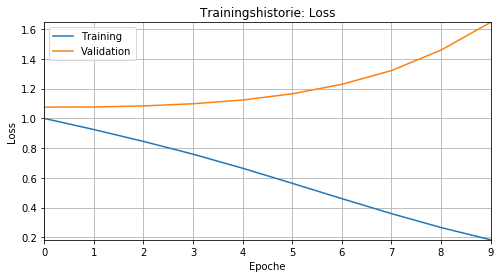

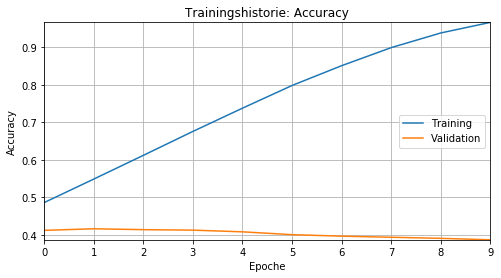

In [46]:
# Plot Modell Historie loss und accuracy
plt.figure(1)
plt.figure(figsize=(8,4))
plt.title('Trainingshistorie: Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlim(0,9)
plt.ylim(np.asarray(hist.history['loss']).min(),np.asarray(hist.history['val_loss']).max())
plt.xticks(np.arange(0, 9.1, step=1))
plt.grid(True)
plt.savefig("trainingshistorieLossVersuch3_.png")
plt.figure(2)
plt.figure(figsize=(8,4))
plt.title('Trainingshistorie: Accuracy')
plt.xticks()
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='right')
plt.xlim(0,9)
plt.ylim(np.asarray(hist.history['val_acc']).min(),np.asarray(hist.history['acc']).max())
plt.xticks(np.arange(0, 9.1, step=1))
plt.grid(True)
plt.savefig("trainingshistorieAccuracyVersuch3_.png")
plt.show()

In [25]:
model.evaluate_generator(dataLoader(xTest, yTest, 32), steps=int(len(xTest)/32))

[1.068480206200801, 0.42143924302788843]

In [24]:
model = load_model('ergebnisse_versuch3/modell_versuch3_3')

In [26]:
validPreds = []
imageList = []
for path in xTest:
    imageList = []   
    img = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
    img = np.array(img)
    img = img.astype('float32')
    img /= 255
    imageList.append(img)
    validPreds.append(model.predict(np.asarray(imageList)))

[[1409  437  794]
 [1010  579 1064]
 [ 878  465 1398]]


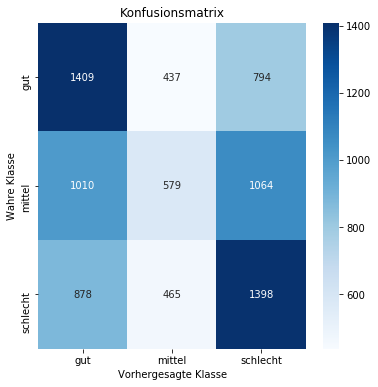

In [28]:
# Konfusionsmatrix
import seaborn as sns
classNames = ['gut','mittel','schlecht'] # Namen der Klassen
validPredArray = np.argmax(np.vstack(validPreds), axis=1)
yTestMax = np.argmax(yTest,axis=1)
cnfMatrix = confusion_matrix(yTestMax, validPredArray)
print(cnfMatrix)
fig, ax = plt.subplots(figsize=(6,6)) 
ax = sns.heatmap(cnfMatrix, fmt="d", cmap=plt.cm.Blues, ax=ax , annot=True)
ax.set_xticklabels(classNames)
ax.set_yticklabels(classNames)
plt.title('Konfusionsmatrix')
plt.ylabel('Wahre Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.savefig('konfmatrixVersuch3_3.png')
plt.show()